# Tests of the SC model

## Notation and model specs to complement what is in the model scoping doc

Value function for a predicted state $\mathbf{x}'$, reached by action $\mathbf{a}$:
* Speed-controlling agent: $V(\mathbf{x}', \mathbf{a}) = k_g v_g - k_c / \tau - k_{dv} v^2 - k_e \Delta v^2$
* Acceleration-controlling agent: $V(\mathbf{x}', \mathbf{a}) = k_g v - k_{sc} a_{sc}^2 - k_{sg} a_{sg}^2 - k_{dv} v^2 - k_{da} a^2 - k_e \Delta a^2$

where $v_g$ is the predicted rate of change of the distance to the goal, $\tau$ predicted time to collision with the other agent (infinite if no collision course), $v$ and $a$ are predicted longitudinal speed and acceleration (all predictions referring to the state $\mathbf{x}'$ after the prediction interval),  $\Delta v$ and $\Delta a$ are the changes in speed or acceleration effectuated by action $\mathbf{a}$, and $a_{sc}$ and $a_{sg}$ are accelerations required to stop just before collision and just before the goal, respectively; the rest above are model parameters.

To see what code variables relate to what model quantities, see comments on the lines initialising the `self.states` variables in `SCAgent.prepare_for_simulation()`.

Conflict between code and scoping doc:
- Code uses a parameter $\kappa$ in $^O A_b(t)$ update, not present in the model scoping doc

## Two pedestrians

(This is the same scenario as in the 2020-06-18 snapshot in my personal OneNote.)


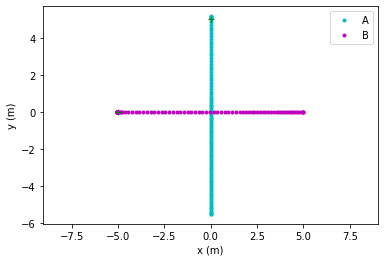

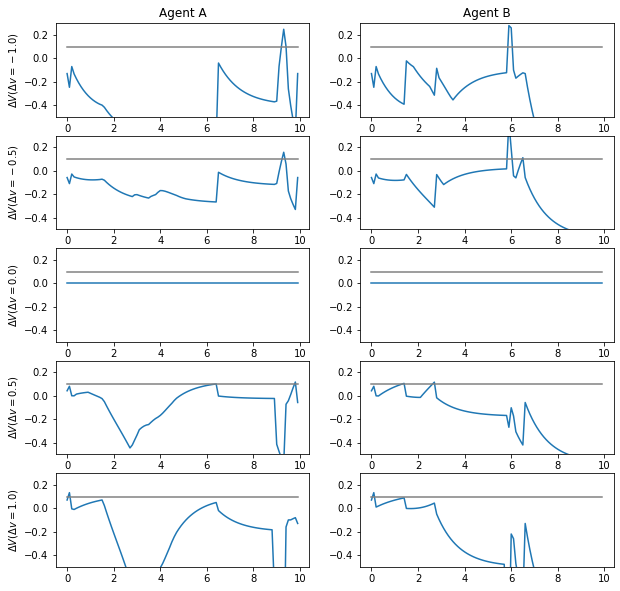

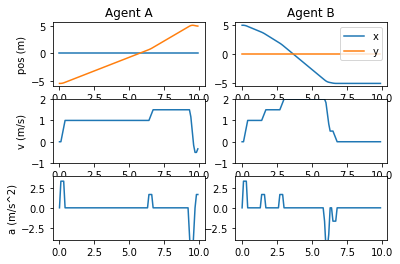

In [2]:
import numpy as np
import importlib
import commotions
import sc_scenario
importlib.reload(sc_scenario)
from sc_scenario import CtrlType

CTRL_TYPES = (CtrlType.SPEED, CtrlType.SPEED)
INITIAL_POSITIONS = np.array([[0,-5.5], [5, 0]])
GOALS = np.array([[0, 5], [-5, 0]])

sc_simulation = sc_scenario.SCSimulation(CTRL_TYPES, GOALS, INITIAL_POSITIONS)
sc_simulation.run()
sc_simulation.do_plots(trajs = True, surplus_action_vals = True, kinem_states = True)